# Human PBMCs from 10X data 

Here we analyse the 10k PBMCs from a healthy donor (v3 chemistry) (Cell Ranger 3.0.0).
Link to the dataset: https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#import preprocessing as scIBpp

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
scanpy==1.4.4+6.ge614f59 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [5]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/pbmc10x_10kv3.h5ad'  # the file that will store the analysis results

In [6]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
#library(slingshot)
#library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [6]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)

In [7]:
# Set up data loading
file_base = '../../Munich/datasets/human/10xPBMC/filtered_feature_bc_matrix/'
adata = sc.read_10x_mtx(path=file_base, var_names='gene_symbols', make_unique=True, cache=True, gex_only=True )

... reading from cache file cache/..-..-Munich-datasets-human-10xPBMC-filtered_feature_bc_matrix-matrix.h5ad


In [8]:
adata

View of AnnData object with n_obs × n_vars = 11769 × 33538 
    var: 'gene_ids', 'feature_types'

In [9]:
adata.var.head()

gene_ids    feature_types
MIR1302-2HG  ENSG00000243485  Gene Expression
FAM138A      ENSG00000237613  Gene Expression
OR4F5        ENSG00000186092  Gene Expression
AL627309.1   ENSG00000238009  Gene Expression
AL627309.3   ENSG00000239945  Gene Expression

In [10]:
adata.X = adata.X.toarray()

In [11]:
adata.var_names_make_unique()

In [12]:
# Checking the total size of the data set
adata.shape

(11769, 33538)

# 1. Pre-processing and visualization

## 1.1 Quality control

In [13]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [14]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']


... storing 'feature_types' as categorical


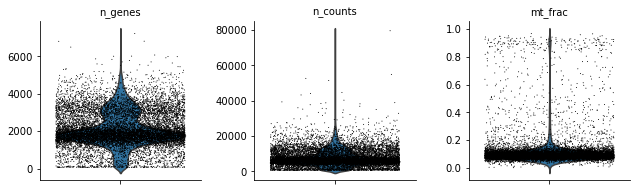

In [15]:
# Quality control - plot QC metrics
sc.pl.violin(adata, ['n_genes', 'n_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

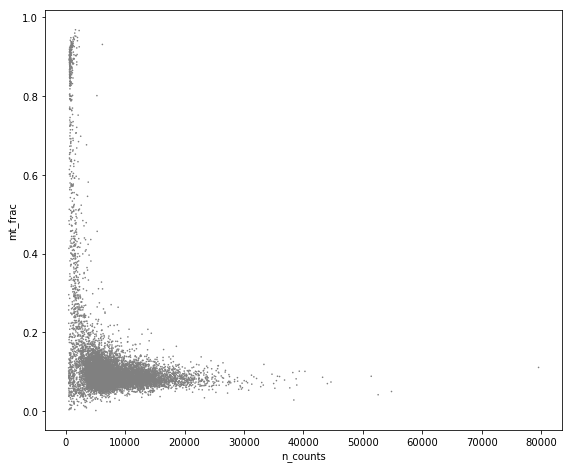

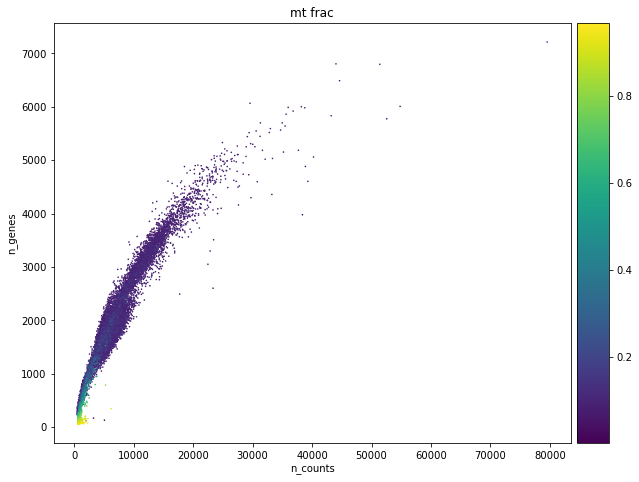

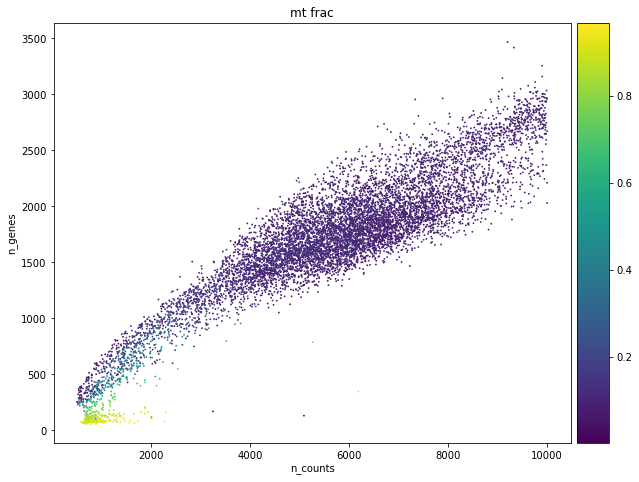

In [17]:
sc.pl.scatter(adata, x='n_counts', y='mt_frac')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')
sc.pl.scatter(adata[adata.obs['n_counts'] < 10000], x='n_counts', y='n_genes', color='mt_frac')

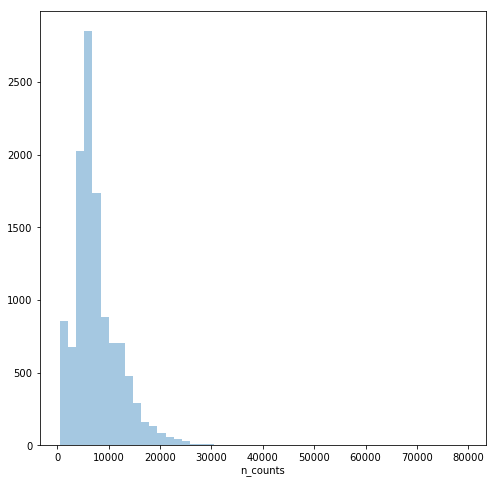

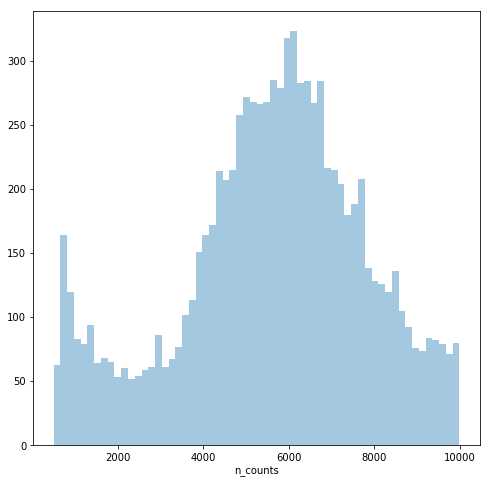

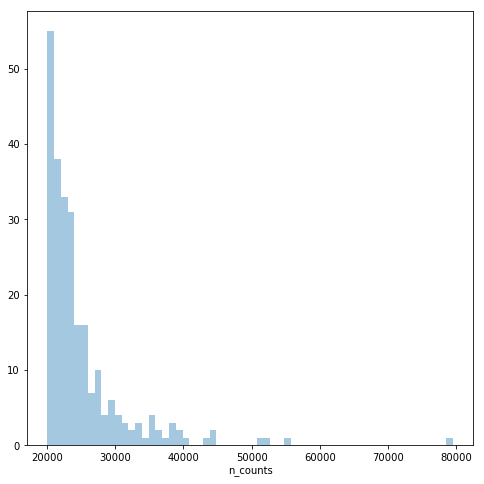

In [18]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<10000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>20000], kde=False, bins=60)
plt.show()

Zoom-in histograms of the number of counts per cell show that there's a smaller group of cells with n_counts < 2000 which are likely uninformative. On the upper end of the distribution, we can see that the high peak centered around 20000 counts spans until around 40000 counts.

In [19]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 2000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))


Total number of cells: 11769
filtered out 825 cells that haveless than 2000 counts
Number of cells after min count filter: 10944
filtered out 8 cells that havemore than 40000 counts
Number of cells after max count filter: 10936
Number of cells after MT filter: 10743


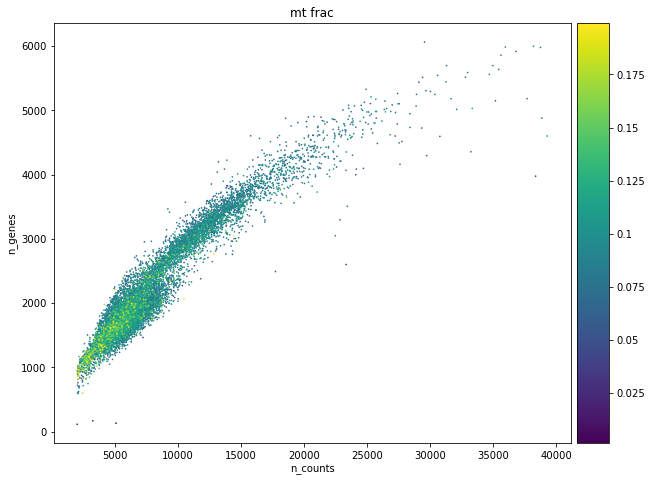

In [20]:
# look at the effect of thresholding
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='mt_frac')

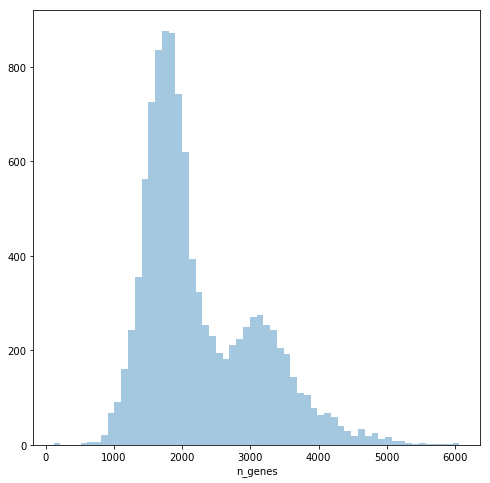

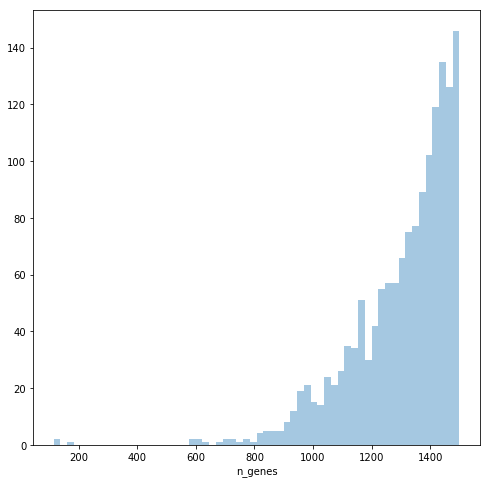

In [21]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1500], kde=False, bins=60)
plt.show()



From the histograms of the number of genes per cell, we can notice that there still is a small population showing n_genes < 800 which should be filtered out.

In [22]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 800)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 10743
filtered out 16 cells that haveless than 800 genes expressed
Number of cells after gene filter: 10727


In [23]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33538
filtered out 17704 genes that are detectedin less than 20 cells
Number of genes after cell filter: 15834


## 1.2 Normalization

In [24]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:08)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01)


In [25]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [26]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [27]:
#Delete adata_pp
del adata_pp

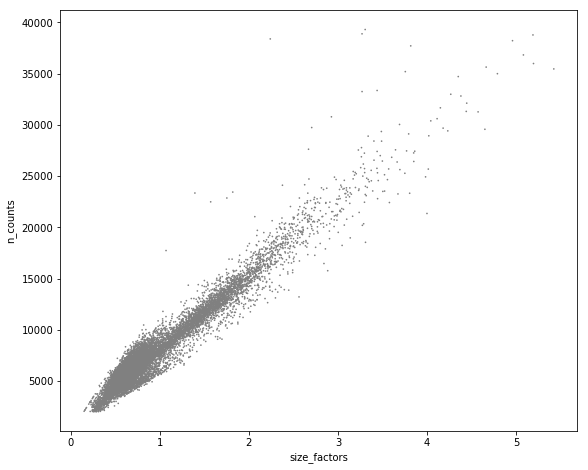

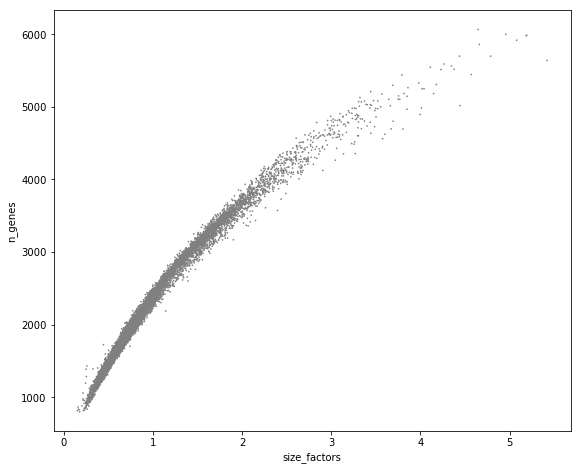

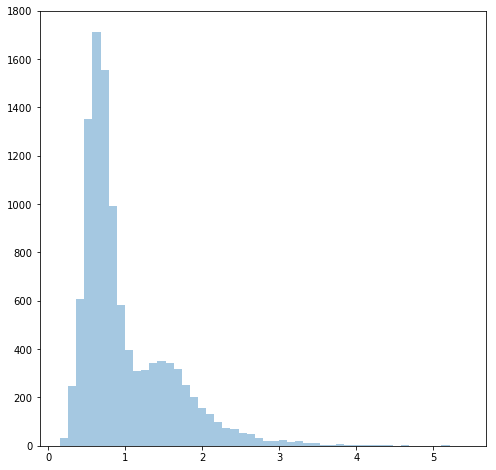

In [28]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [29]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [30]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [31]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

## 1.3 Highly variable genes

In [32]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


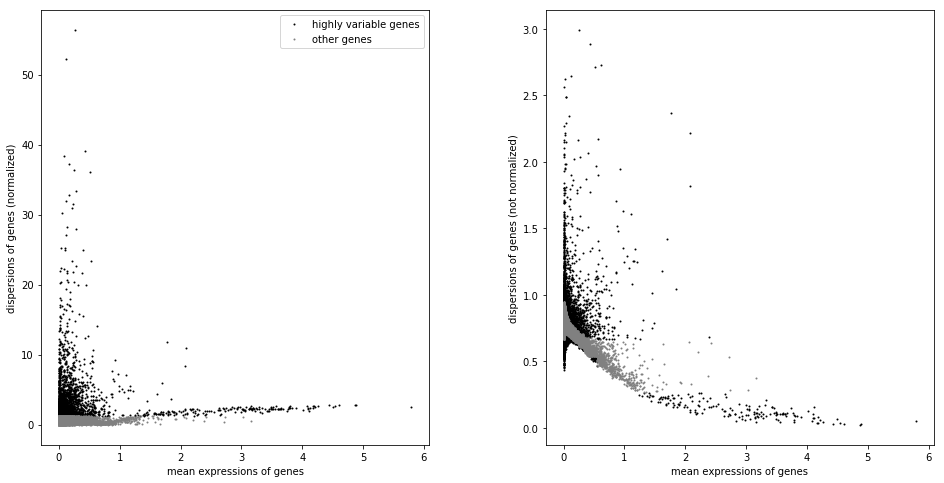

In [33]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [34]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:05)
computing UMAP


/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:21)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9998986  0.9994045  0.9982399  0.99672824
     0.99216354 0.98910457 0.98872167 0.9861633  0.98209685 0.9819014
     0.9780419  0.9762579  0.9731303 ]
    finished (0:00:02)
drawing single-cell graph using layout 'fa'
    finished (0:02:52)


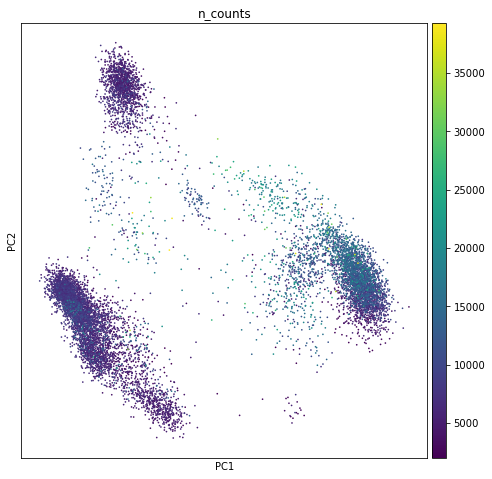

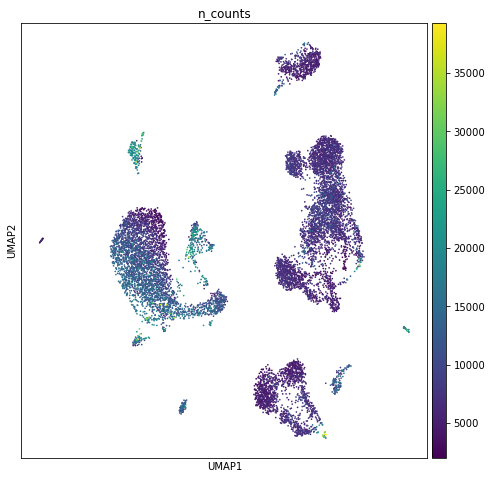

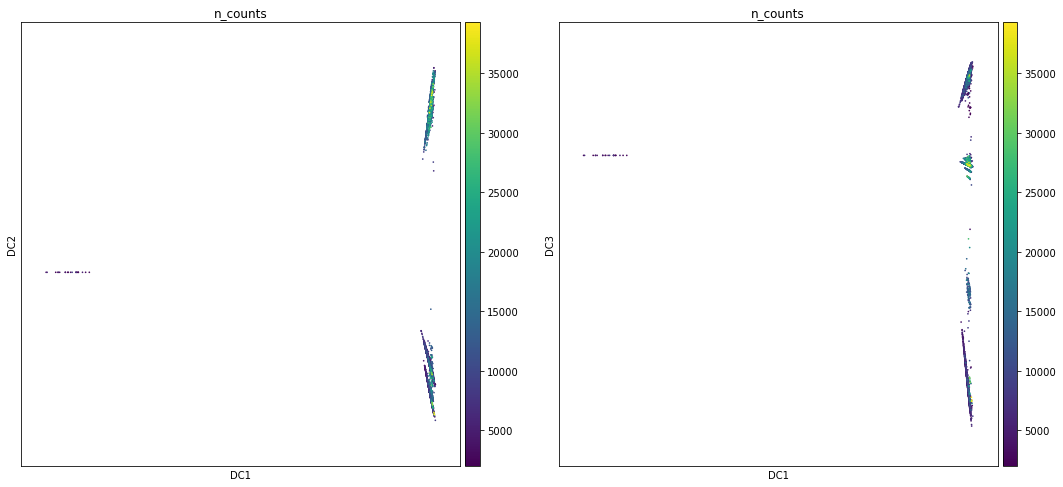

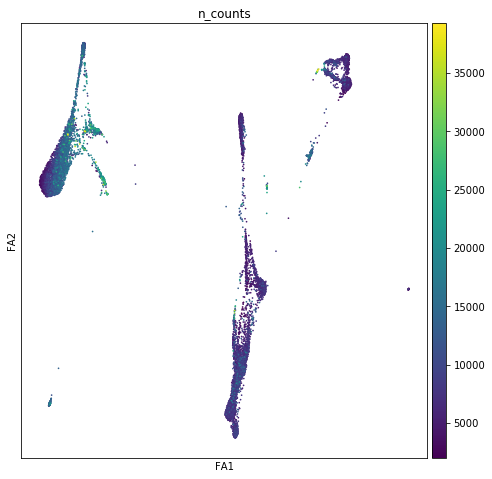

In [35]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

In [36]:
adata.write(results_file)

# 3. Clustering

In [38]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01)


In [39]:
adata.obs['louvain_r0.5'].value_counts()

0     3071
1     2049
2     1446
3     1435
4     1013
5      602
6      369
7      311
8      183
9      118
10      81
11      28
12      21
Name: louvain_r0.5, dtype: int64

In [40]:
adata.obs['louvain_r1'].value_counts()

0     1910
1     1610
2     1121
3     1119
4      796
5      603
6      600
7      559
8      394
9      380
10     343
11     284
12     242
13     237
14     207
15     118
16      81
17      74
18      28
19      21
Name: louvain_r1, dtype: int64

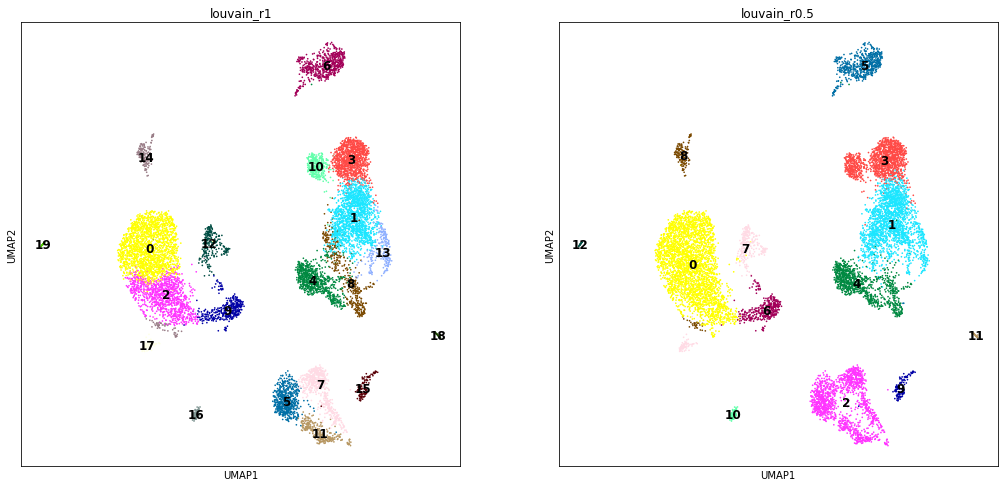

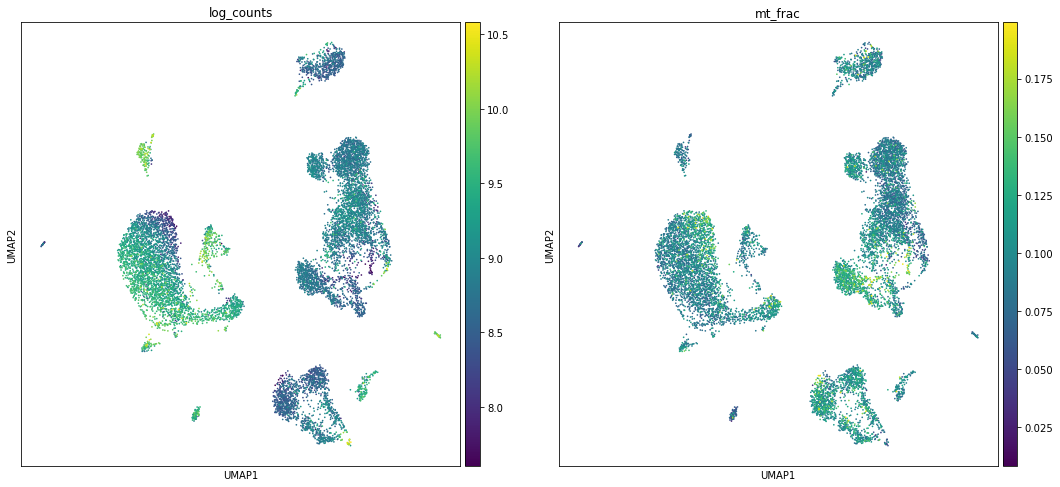

In [41]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])



# 4. Marker genes and cluster annotation (r 0.5)

## 4.1 Short list of cell types (PanglaoDB)

In [42]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished (0:00:18)


In [43]:
# Known marker genes taken from PanglaoDB (short list of 12 cell types)
markers_short_df = pd.read_csv('../../Munich/Immune_markers_short_12.txt', delimiter='\t')
markers_short_df.shape

(975, 14)

In [44]:
markers_short_df.head()

species official.gene.symbol cell.type         nicknames  \
417   Mm Hs                  CD2   B cells               NaN   
418   Mm Hs                  CD5   B cells               NaN   
419   Mm Hs                MS4A1   B cells   Bp35|MS4A2|CD20   
420   Mm Hs                  CR2   B cells         CD21|C3DR   
421   Mm Hs                 CD22   B cells  SIGLEC-2|SIGLEC2   

     ubiquitousness.index             product.description  \
417                 0.040                    CD2 molecule   
418                 0.004                    CD5 molecule   
419                 0.014  membrane spanning 4-domains A1   
420                 0.001       complement C3d receptor 2   
421                 0.003                   CD22 molecule   

               gene.type  canonical.marker germ.layer          organ  \
417  protein-coding gene               NaN   Mesoderm  Immune system   
418  protein-coding gene               1.0   Mesoderm  Immune system   
419  protein-coding gene               1.0   Mesoderm  Immune system   
420  protein-coding gene               1.0   Mesoderm  Immune system   
421  protein-coding gene               1.0   Mesoderm  Immune system   

     sensitivity_human  sensitivity_mouse  specificity_human  \
417           0.000000           0.212355           0.095847   
418           0.000000           0.000000           0.004153   
419           0.483871           0.617761           0.011182   
420           0.048387           0.034749           0.000000   
421           0.096774           0.127413           0.001278   

     specificity_mouse  
417           0.026556  
418           0.004502  
419           0.001566  
420           0.000000  
421           0.000196

Select only genes that are annotated for human:

In [45]:
markers_short_df_hum = markers_short_df[(markers_short_df['species'] == 'Hs') | (markers_short_df['species'] == 'Mm Hs')]
markers_short_df_hum.shape

(892, 14)

In [46]:
cell_types = list(markers_short_df_hum['cell.type'].unique())

In [47]:
markers_dict = {}

In [48]:
for ctype in cell_types:
    df = markers_short_df_hum[markers_short_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [49]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5')
cell_annotation
    

0     1     2    3     4  \
B cells                                        2.0   3.0  34.0  1.0   3.0   
B cells naive                                  0.0   2.0  31.0  0.0   2.0   
Dendritic cells                               15.0   0.0  11.0  1.0   5.0   
Erythroid-like and erythroid precursor cells   3.0   0.0   0.0  0.0   0.0   
Gamma delta T cells                            0.0   0.0   0.0  0.0  12.0   
Monocytes                                     13.0   0.0   2.0  0.0   1.0   
NK cells                                       1.0   5.0   0.0  1.0  22.0   
Plasmacytoid dendritic cells                   2.0   1.0   7.0  1.0   2.0   
Platelets                                      4.0   1.0   2.0  0.0   3.0   
T cells                                        1.0  15.0   2.0  7.0  27.0   
T cytotoxic cells                              0.0   3.0   0.0  1.0   4.0   
T memory cells                                 2.0  13.0   1.0  7.0  12.0   

                                                 5     6     7     8     9  \
B cells                                        0.0   1.0   1.0   4.0  35.0   
B cells naive                                  0.0   0.0   0.0   4.0  31.0   
Dendritic cells                                6.0  12.0  16.0  16.0   9.0   
Erythroid-like and erythroid precursor cells   1.0   0.0   3.0   0.0   0.0   
Gamma delta T cells                           18.0   0.0   0.0   1.0   0.0   
Monocytes                                      3.0   8.0  14.0   3.0   2.0   
NK cells                                      29.0   3.0   2.0   2.0   1.0   
Plasmacytoid dendritic cells                   2.0   0.0   2.0   0.0   6.0   
Platelets                                      6.0   2.0   4.0   1.0   3.0   
T cells                                       17.0   1.0   1.0   0.0   3.0   
T cytotoxic cells                              1.0   0.0   0.0   0.0   1.0   
T memory cells                                 4.0   0.0   2.0   0.0   2.0   

                                                10   11    12  
B cells                                        8.0  2.0   0.0  
B cells naive                                  3.0  0.0   0.0  
Dendritic cells                                5.0  3.0   0.0  
Erythroid-like and erythroid precursor cells   0.0  0.0   3.0  
Gamma delta T cells                            3.0  1.0   1.0  
Monocytes                                      1.0  1.0   0.0  
NK cells                                       1.0  0.0   2.0  
Plasmacytoid dendritic cells                  21.0  2.0   1.0  
Platelets                                      4.0  2.0  30.0  
T cells                                        1.0  2.0   1.0  
T cytotoxic cells                              1.0  0.0   0.0  
T memory cells                                 0.0  0.0   1.0

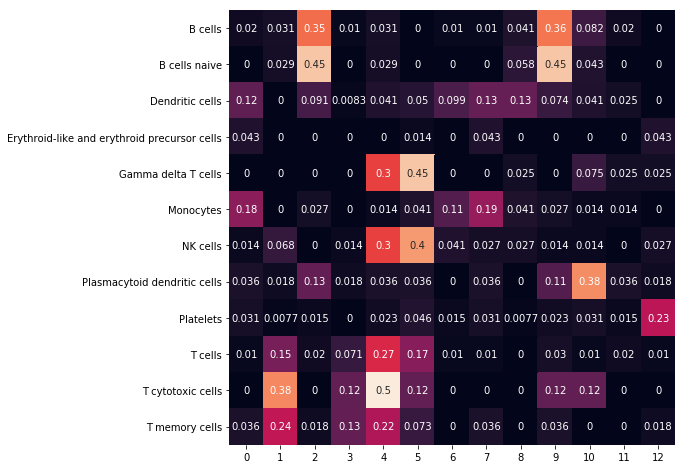

In [50]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [51]:
#Categories to rename
adata.obs['louvain_r0.5'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')

In [52]:
adata.obs['cell_type0.5short'] = adata.obs['louvain_r0.5']
adata.obs['cell_type0.5short'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')

In [53]:
adata.rename_categories('cell_type0.5short', ['Monocytes1', 'T cytotoxic1', 'B cells naive1', 'T memory', 'T cyctotoxic + NK', 'Gamma delta T cells + NK', 'Monocytes2', 'Monocytes3', 'Dendritic cells', 'B cells naive2', 'Plasmacytoid dendritic cells', 'Unknown', 'Platelets'])

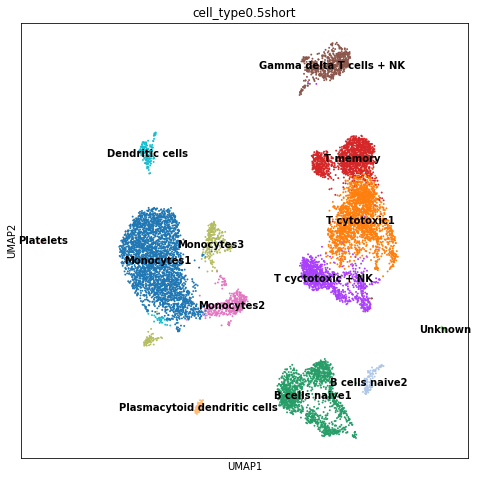

In [54]:
sc.pl.umap(adata, color='cell_type0.5short', size=15, legend_loc='on data')

## 4.2 Long list of cell types
Here we try using the long list of cell types (29) from PanglaoDB, considering all cell types in "immune system" + "blood". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [55]:
markers_long_df = pd.read_csv('../../Munich/Immune_markers_long_29.txt', delimiter='\t')
markers_long_df.shape

(1866, 14)

In [56]:
markers_long_df = markers_long_df[markers_long_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_long_df.shape

(1849, 14)

In [57]:
markers_long_df = markers_long_df[markers_long_df['cell.type'] != 'Red pulp macrophages']
markers_long_df.shape

(1837, 14)

In [58]:
markers_long_df_hum = markers_long_df[(markers_long_df['species'] == 'Hs') | (markers_long_df['species'] == 'Mm Hs')]
markers_long_df_hum.shape

(1685, 14)

In [59]:
cell_types = list(markers_long_df_hum['cell.type'].unique())

In [60]:
markers_dict_long = {}
for ctype in cell_types:
    df = markers_long_df_hum[markers_long_df_hum['cell.type'] == ctype]
    markers_dict_long[ctype] = df['official.gene.symbol'].to_list()

In [61]:
cell_annotation_long = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5')

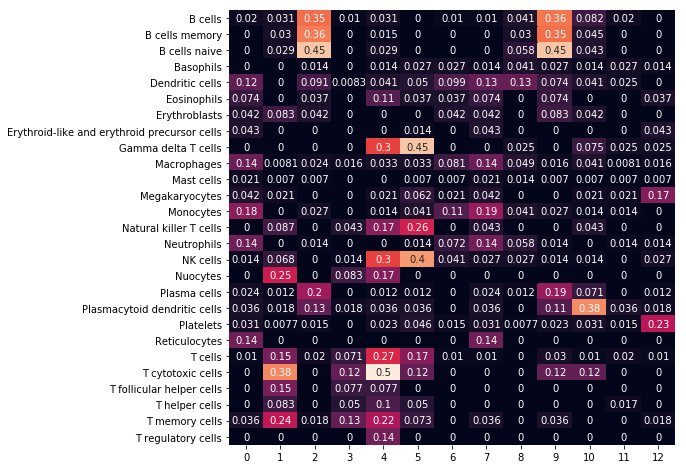

In [62]:
cell_annotation_long_norm = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r0.5', normalize='reference')
sb.heatmap(cell_annotation_long_norm, cbar=False, annot=True)

In [63]:
# Categories to rename
adata.obs['cell_type0.5long'] = adata.obs['louvain_r0.5']
adata.rename_categories('cell_type0.5long', ['Monocytes1', 'T cytotoxic1', 'B cells naive1', 'T memory', 'T cyctotoxic + NK', 'Gamma delta T cells + NK', 'Monocytes2', 'Monocytes3', 'Dendritic cells', 'B cells naive2', 'Plasmacytoid dendritic cells', 'Unknown', 'Platelets'])

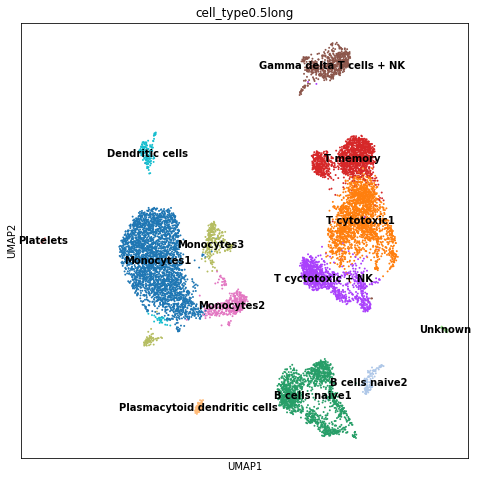

In [64]:
sc.pl.umap(adata, color='cell_type0.5long', size=15, legend_loc='on data')

Using the long list did NOT actually improve the annotation

# 5. Markers and cluster annotation (r 1)

In [65]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')
cell_annotation_long_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1')

ranking genes
    finished (0:00:25)


## 5.1 Short list of cell types

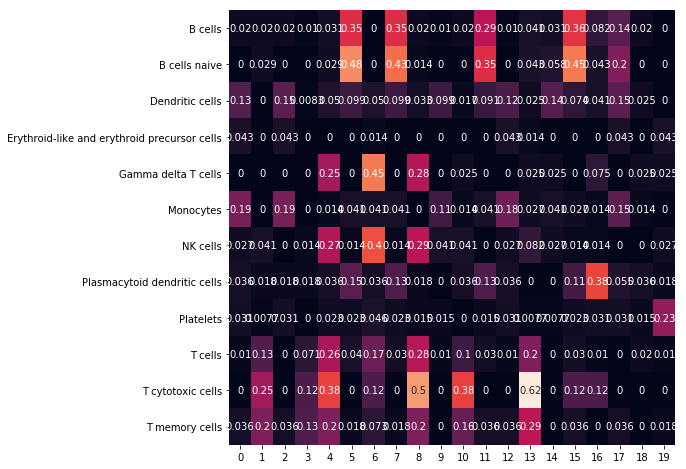

In [66]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [67]:
# Categories to rename
adata.obs['cell_type1short'] = adata.obs['louvain_r1']
adata.rename_categories('cell_type1short', ['Monocytes1', 'T cytotoxic1', 'Monocytes2', 'T memory1', 'T cytotoxic2', 'B cells naive1', 'Gamma delta T cells + NK', 'B cells naive2', 'T cytotoxic3', 'Monocytes3', 'T cytotoxic4', 'B cells naive3', 'Monocytes4', 'T cytotoxic5', 'Dendritic cells', 'B cells naive4',  'Plasmacytoid dendritic cells', 'B cells naive 5', 'Unknown', 'Platelets'])

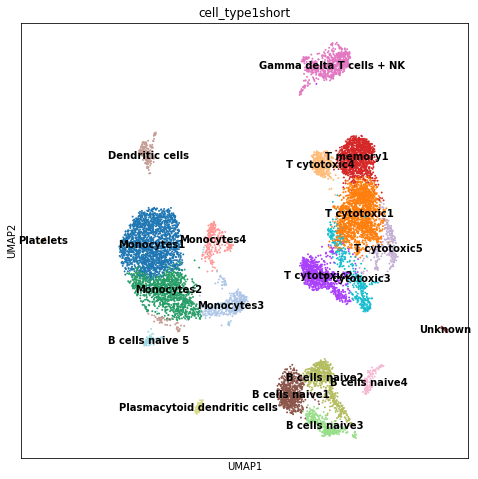

In [68]:
sc.pl.umap(adata, color='cell_type1short', size=15, legend_loc='on data')

## 5.2 Long list of cell types

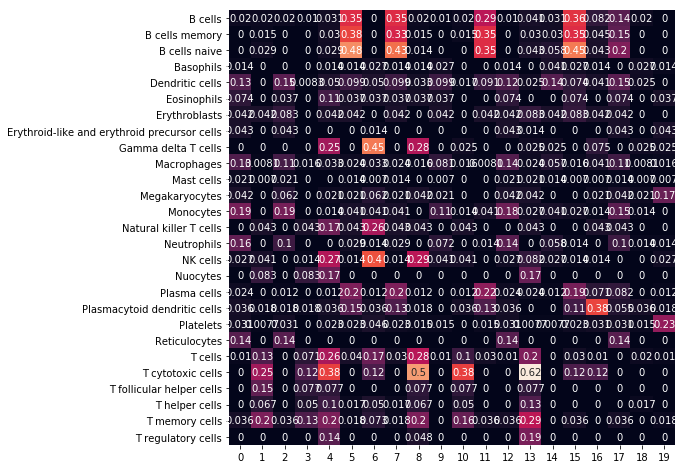

In [69]:
cell_annotation_long_norm_r1 = sc.tl.marker_gene_overlap(adata, markers_dict_long, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_long_norm_r1, cbar=False, annot=True)

In [70]:
adata.write(results_file)

# 6. Plot makers of subtypes

In [71]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## T cells

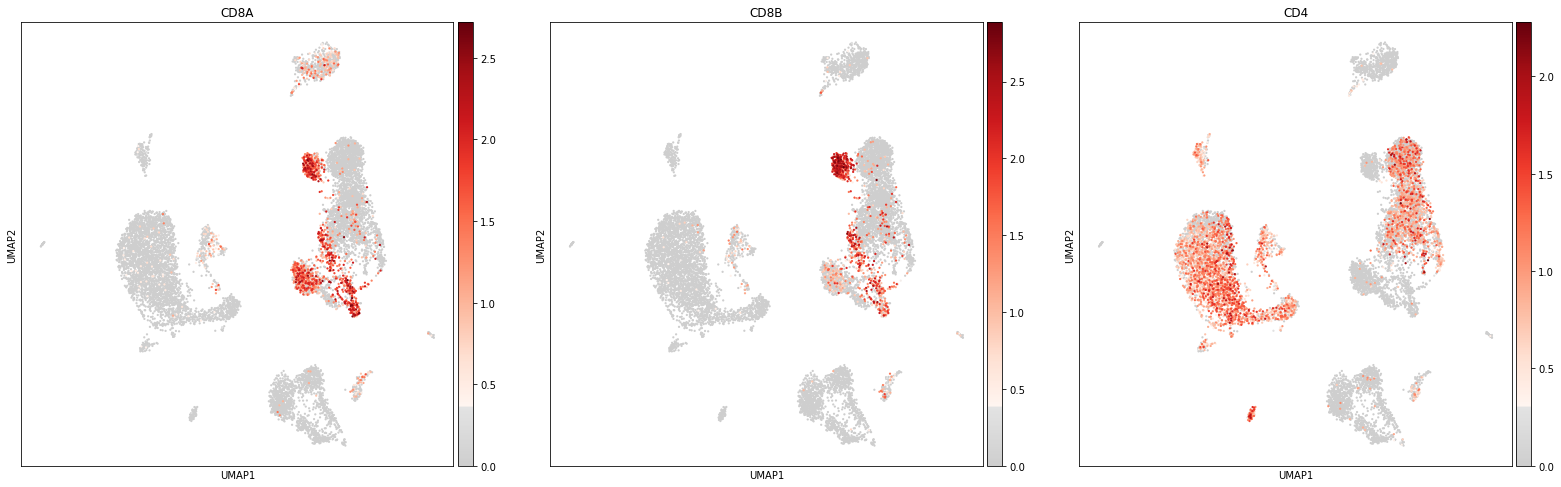

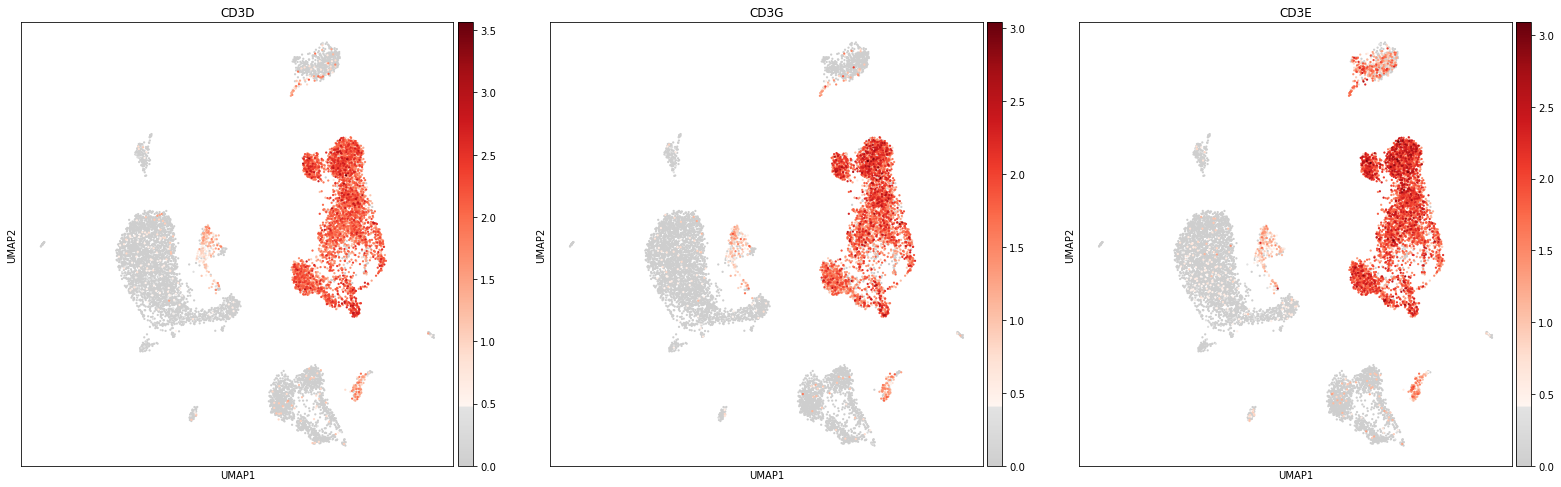

In [72]:
#Canonical markers
sc.pl.umap(adata, color=['CD8A','CD8B', 'CD4'], use_raw=False, color_map=mymap, size = 20)
sc.pl.umap(adata, color=['CD3D', 'CD3G', 'CD3E'], use_raw=False, color_map=mymap, size = 20)

Cluster 4 (louvain r1) seems to be composed by 2 subclusters, one being CD8- CD4- CD3+ for which we can cite [D'Acquisto et al.](https://www.ncbi.nlm.nih.gov/pubmed/21640713)

### Natural killer T cells

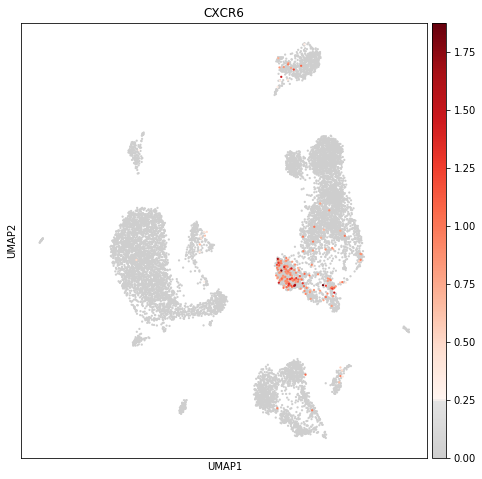

In [73]:
sc.pl.umap(adata, color=['CXCR6'], use_raw=False, color_map=mymap, size = 20)

Other part of cluster 4 seems to be NKT [Stegmann et al.](https://www.nature.com/articles/srep26157)

### T regulatory cells

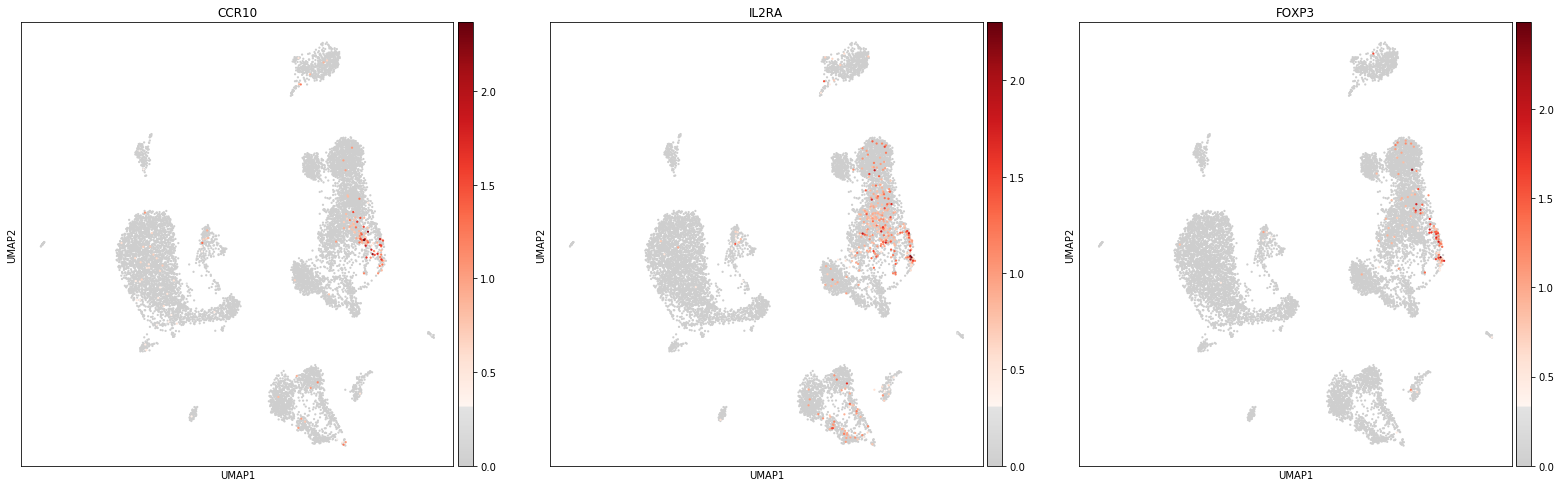

In [74]:
#Canonical markers
sc.pl.umap(adata, color=['CCR10','IL2RA', 'FOXP3'], use_raw=False, color_map=mymap, size = 20)


Cluster 13 (r1) is also CD4+, so T reg! [Ballke et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4751285/)

### T memory cells

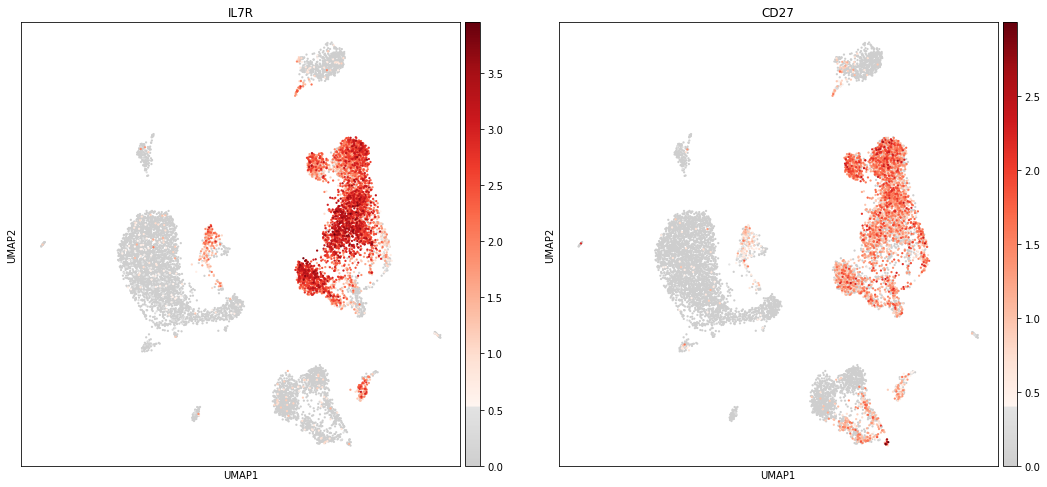

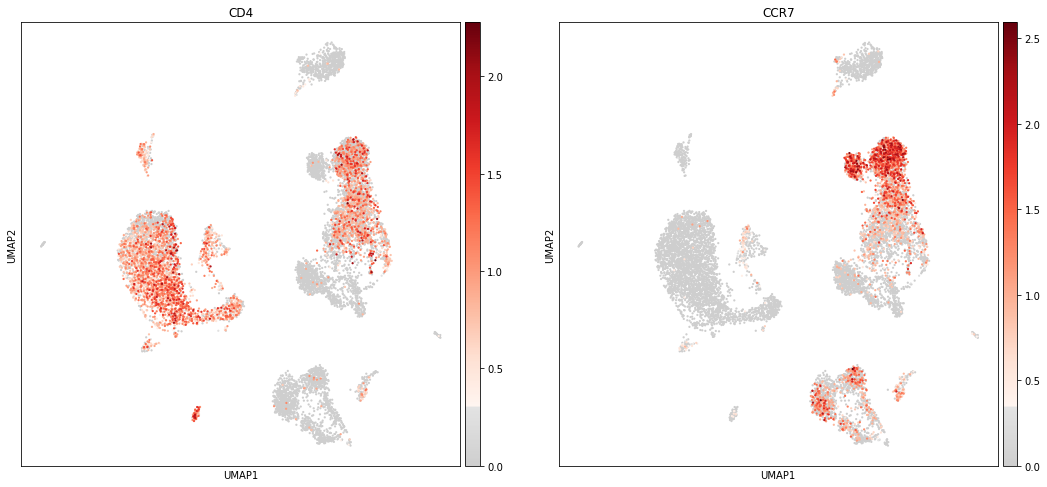

In [75]:
sc.pl.umap(adata, color=['IL7R','CD27'], use_raw=False, color_map=mymap, size = 20)
sc.pl.umap(adata, color=['CD4', 'CCR7'], use_raw=False, color_map=mymap, size = 20)


Clusters 3 and 1 are CD4+ T mem. (from [CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?species=Human&tissue=Blood&cellname=T%20cell))

### Naive CD8+ T cells

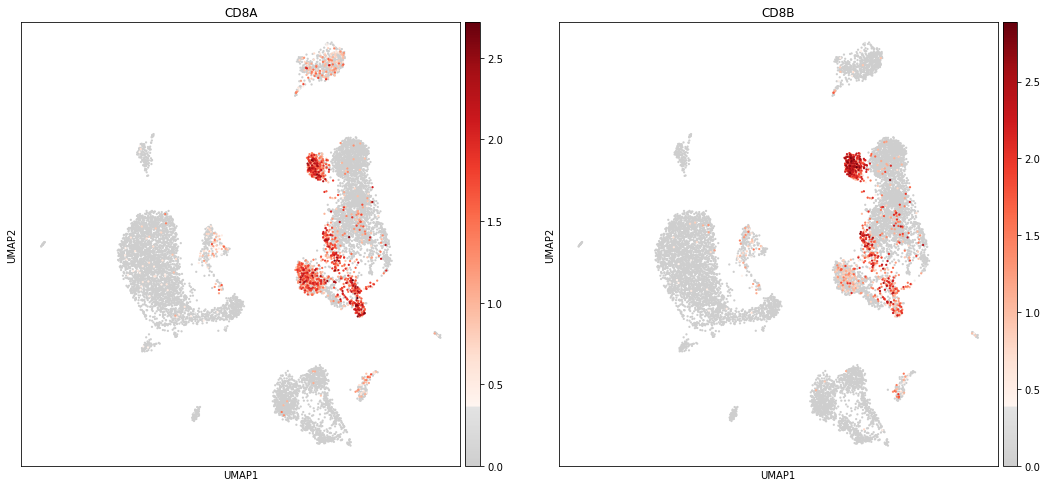

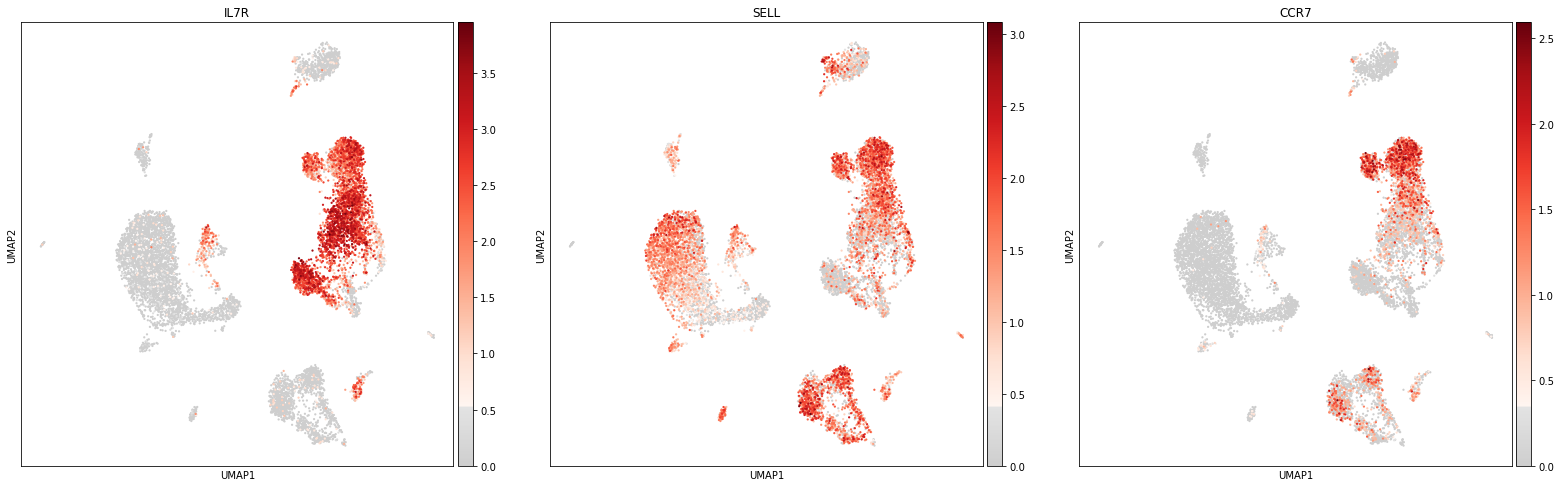

In [76]:
sc.pl.umap(adata, color=['CD8A','CD8B'], use_raw=False, color_map=mymap, size = 20)
sc.pl.umap(adata, color=['IL7R', 'SELL', 'CCR7'], use_raw=False, color_map=mymap, size = 20)

Cluster 10 !! [Samji et al.](https://www.ncbi.nlm.nih.gov/pubmed/28274794)

### Cytotoxic T cells

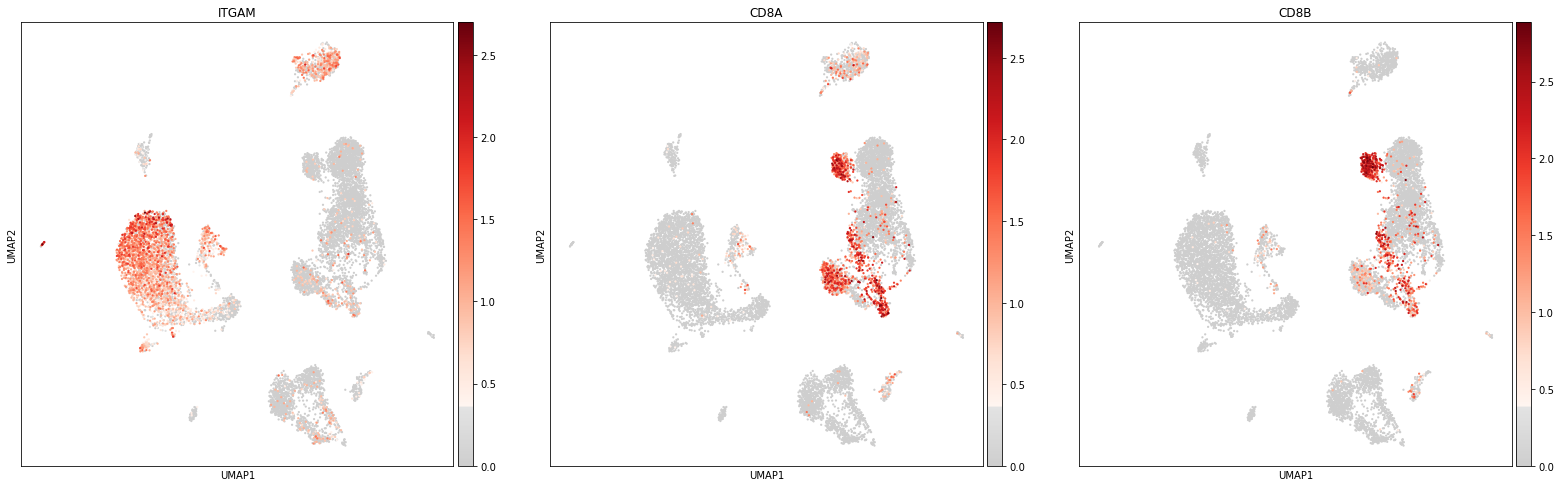

In [77]:
sc.pl.umap(adata, color=['ITGAM','CD8A', 'CD8B'], use_raw=False, color_map=mymap, size = 20)

Cluster 6 is clearly Cytotoxic T cells ([CellMarker](http://biocc.hrbmu.edu.cn/CellMarker/search.jsp?species=Human&tissue=Blood&cellname=T%20cell))

### Gamma delta T cells

These should be CD4- CD8- so probably the small part of cluster 4 

## NK cells

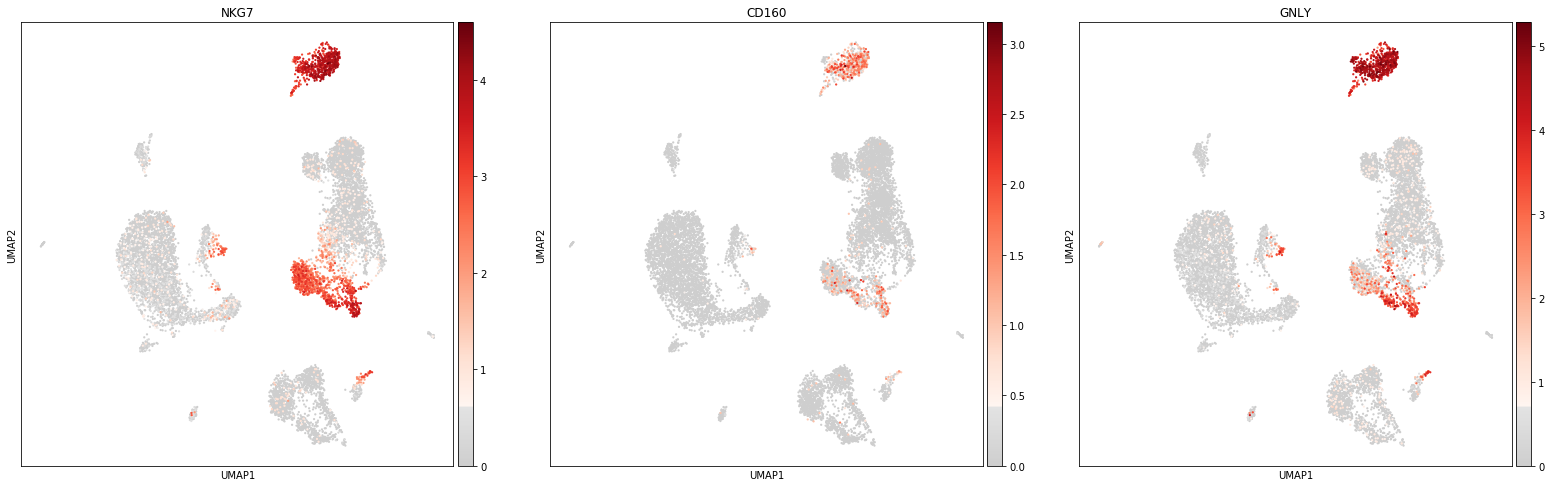

In [78]:
sc.pl.umap(adata, color=['NKG7','CD160', 'GNLY'], use_raw=False, color_map=mymap, size = 20)

## Monocytes: CD14+ and CD16+

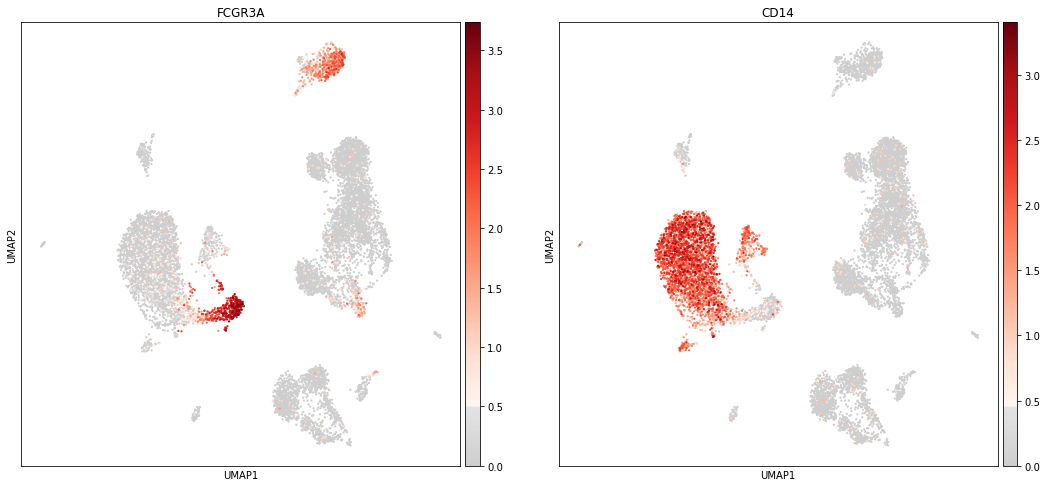

In [79]:
sc.pl.umap(adata, color=['FCGR3A','CD14'], use_raw=False, color_map=mymap, size = 20)

## Monocyte-derived Dendritic cells

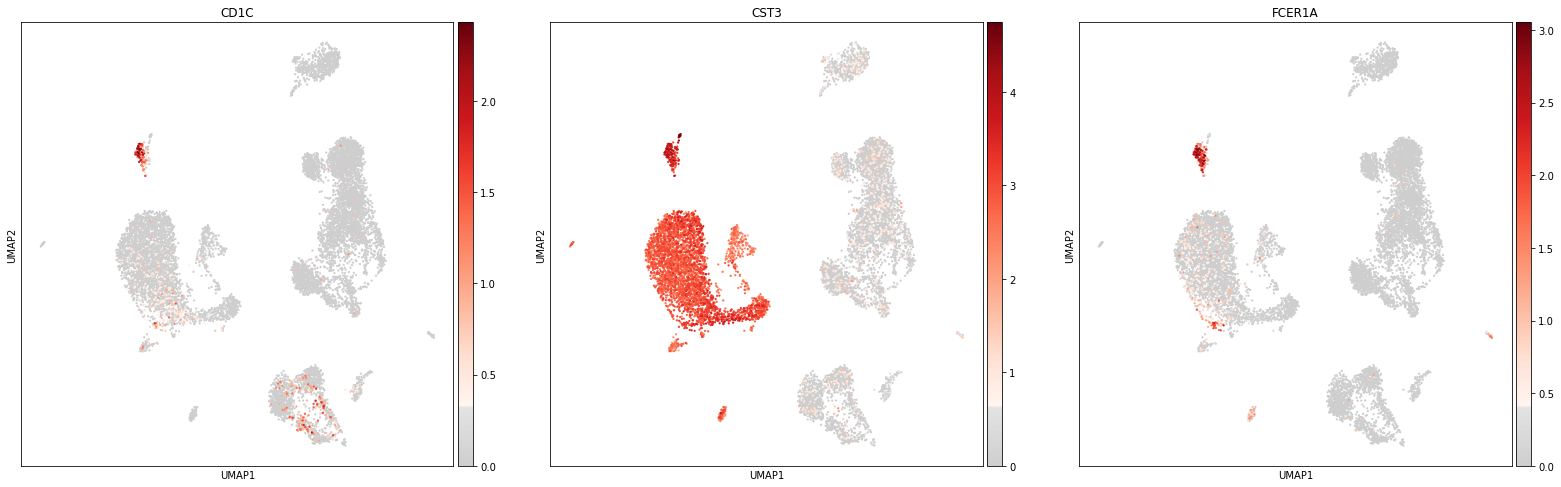

In [80]:
sc.pl.umap(adata, color=['CD1C', 'CST3', 'FCER1A'], use_raw=False, color_map=mymap, size = 20)

Cluster 14 (confirmed) [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

## B cells

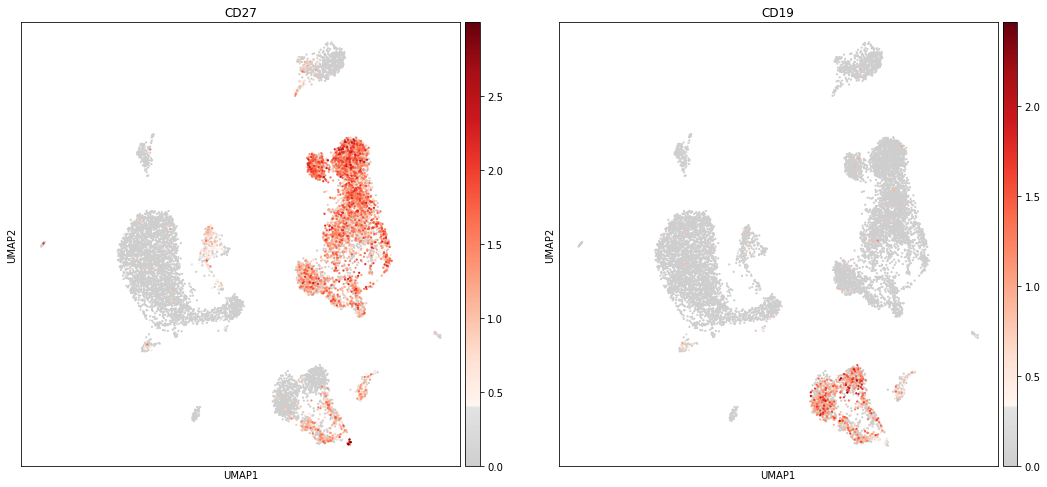

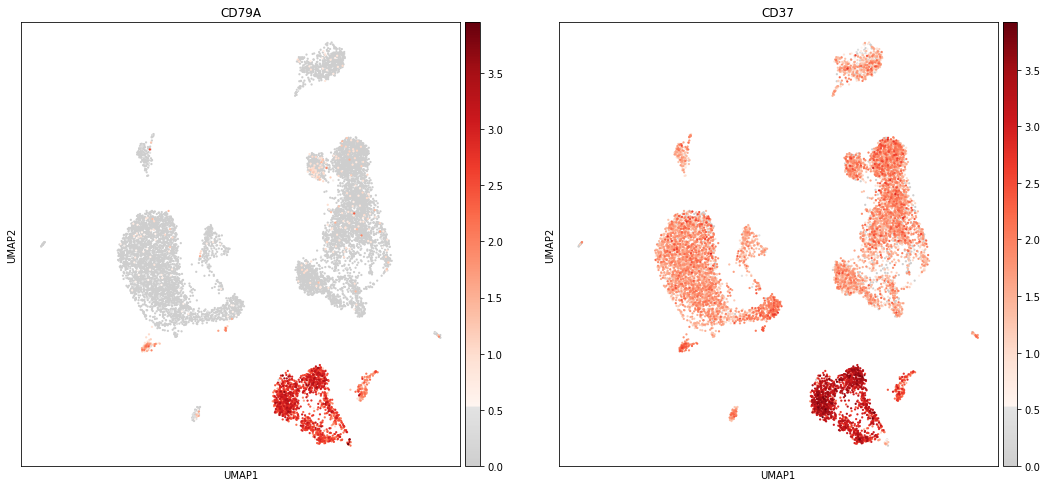

In [81]:
sc.pl.umap(adata, color=['CD27', 'CD19'], use_raw=False, color_map=mymap, size = 20)
sc.pl.umap(adata, color=['CD79A', 'CD37'], use_raw=False, color_map=mymap, size = 20)

I could not find specific markers for memory/naive B cells. First 2 markers are from CellMarker, second 2 from Sinha et al.

# 7. Semi-final cell-type annotation

In [82]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain_r1']
adata.rename_categories('final_annotation', ['CD14+ Monocytes, 1', 'CD4+ T memory, 1', 'CD14+ Monocytes, 2', 'CD4+ T memory, 2', 'NKT + NK cells + DN T cells', 'B cells, 1', 'T cytotoxic + NK cells', 'B cells, 2', 'NK cells', 'CD16+ Monocytes', 'CD8+ Naive T cells', 'B cells, 3', 'CD14+ Monocytes, 3', 'T regulatory cells', 'Monocytes-derived dendritic cells', 'B cells, 4',  'Plasmacytoid dendritic cells', 'CD14+ Monocytes, 4', 'Unknown', 'Platelets'])

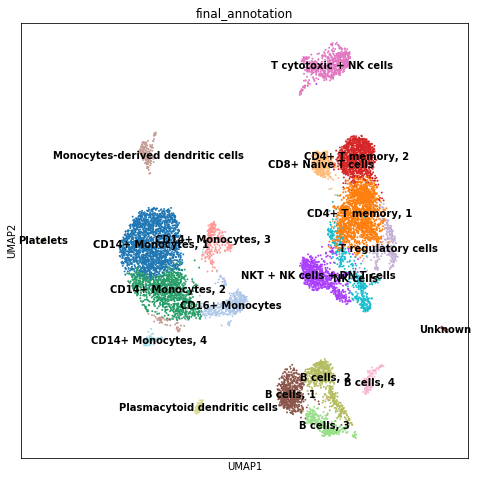

In [83]:
sc.pl.umap(adata, color='final_annotation', size=15, legend_loc='on data')

# 8. Subclustering

We decide to subcluster cluster 4 (NKT+ NKcells + double negative cells) with the aim to better separate these DN cells

In [92]:
#Subcluster cluster4
sc.tl.louvain(adata, restrict_to=('final_annotation', ['NKT + NK cells + DN T cells']), resolution=0.2, key_added='final_annotation_clust4_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


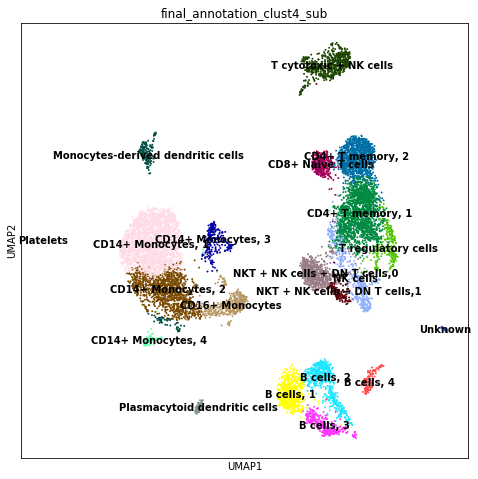

In [93]:
#Show the new clustering
if 'final_annotation_clust4_sub_colors' in adata.uns:
    del adata.uns['final_annotation_clust4_sub_colors']

sc.pl.umap(adata, color='final_annotation_clust4_sub', size = 15, legend_loc = 'on data', palette=sc.pl.palettes.godsnot_64)

This works perfectly, separating cluster 4 into NKT+NK(4,0) and double negative T cells (4,1)

# 9. Refined, final annotation

In [99]:
tmp = adata.obs['final_annotation_clust4_sub']
tmp.cat.categories

Index(['B cells, 1', 'B cells, 2', 'B cells, 3', 'B cells, 4',
       'CD4+ T memory, 1', 'CD4+ T memory, 2', 'CD8+ Naive T cells',
       'CD14+ Monocytes, 1', 'CD14+ Monocytes, 2', 'CD14+ Monocytes, 3',
       'CD14+ Monocytes, 4', 'CD16+ Monocytes',
       'Monocytes-derived dendritic cells', 'NK cells',
       'NKT + NK cells + DN T cells,0', 'NKT + NK cells + DN T cells,1',
       'Plasmacytoid dendritic cells', 'Platelets', 'T cytotoxic + NK cells',
       'T regulatory cells', 'Unknown'],
      dtype='object')

In [101]:
tmp = ['B cells' if item.startswith('B cells') else item for item in tmp]
tmp = ['CD4+ T memory' if item.startswith('CD4+ T memory') else item for item in tmp]
tmp = ['CD14+ Monocytes' if item.startswith('CD14+ Monocytes') else item for item in tmp]
tmp = ['NKT + NK cells' if item == 'NKT + NK cells + DN T cells,0' else item for item in tmp]
tmp = ['DN T cells' if item == 'NKT + NK cells + DN T cells,1' else item for item in tmp]

In [102]:
adata.obs['final_annotation'] = tmp

... storing 'final_annotation' as categorical


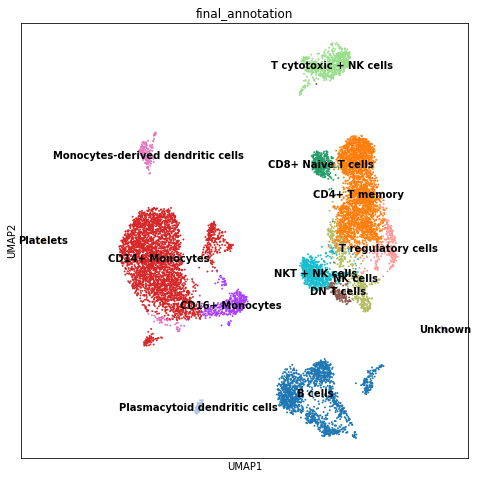

In [103]:
sc.pl.umap(adata, color='final_annotation', size=15, legend_loc='on data')

## 9.1 Check for Unknown cluster features

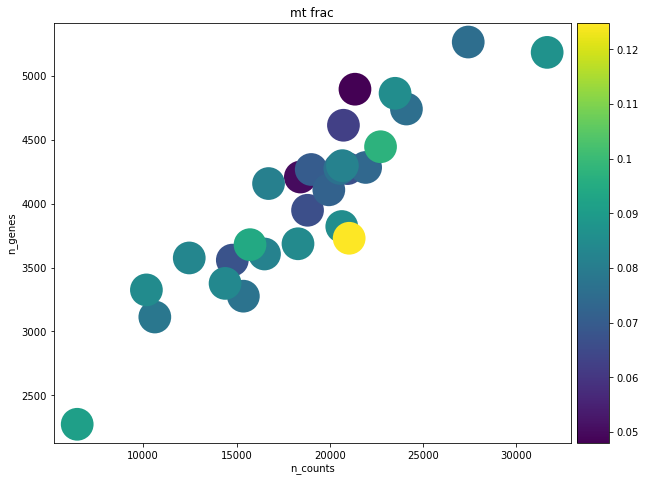

In [104]:
sc.pl.scatter(adata[adata.obs['final_annotation'] == 'Unknown'], x='n_counts', y='n_genes', color='mt_frac')

It does not seem to have any particular technical issue. We remove it anyway.

In [105]:
adata.shape

(10727, 15834)

In [106]:
adata = adata[adata.obs['final_annotation'] != 'Unknown']
adata.shape

(10699, 15834)

In [107]:
# save final result
adata.write(results_file)